In [1]:
using SparseArrays , Statistics , PyPlot
include("variational_montecarlo_3.jl");

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand\dag\dagger$
## Variational Montecarlo

#### Given:
- single particle in 1D chain with L sites
- 1D chain in space mode representation, i.e. $\ket{x_{i}}$=$\ket{0,0,\dots ,1, \dots ,0}$  , $i=1 ,\dots , L $
- An Hamiltonian including only diagonal and hopping terms (tridiagonal)
- A variational trial state $\ket{\Psi}$ such that $\braket{x_{i}}{\Psi} = e^{-g i}$ with $g$ variational parameter

#### Find, using the Metroplis algorithm
- Optimal $g$ (to have an optimal ground state)
- average value of the position $ < O > $  ,$ O = \sum_{i} ic_{i}^\dag c_{i}$ 


### 0) Problem parameters

In [2]:
L=30
V=5.0
t=1.0
V_=V/t
g=1.;

### 1) Hamiltonian representation
 $$ H_{i,j} = \braket{x_{i}}{H x_{j}} = -t \left( \delta_{i,j+1} + \delta_{i,j-1} \right)+2 V (j-1) \delta_{i,j} \quad i,j = 1, \dots , L $$ 
 Using adjacency matrices, we can represent it with the adjacency list :
 $$ (1,1),(1,2),(2,1),(2,2),(2,3) \dots $$ so in general :
 $\begin{cases}
  \& (i,i-1),(i,i),(i,i+1) \quad \text{for} \quad i=2, \dots , L-1  \\
  \& (i,i) , (i,i+1) \quad \text{for} \quad i=1 \\
  \& (i,i-1) , (i,i) \quad \text{for} \quad i = L \\
 \end{cases} $

In [3]:
n=2 #la block analysis lavora su bin che si dimezzano a ogni passo
nmeas=n^13
nhop=1 #numero di hopping fra una misura e la successiva
output , chain=mcchain(L,t,V,g,nmeas=nmeas,nhop=nhop);
chain.H

30×30 Array{Float64,2}:
  0.0  -1.0   0.0   0.0   0.0   0.0  …    0.0    0.0    0.0    0.0    0.0
 -1.0  10.0  -1.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0  -1.0  20.0  -1.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0  -1.0  30.0  -1.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0  -1.0  40.0  -1.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0  -1.0  50.0  …    0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0  -1.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …    0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  ⋮           

## Analisi errori
- Dividi in bin
- calcola la media dell'energia per ogni bin
- Calcola la deviazione standard per ogni bin
- Dividi in bin più piccoli
- Ripeti

Fallo per N_ensamble prese dati. Media quindi le deviazioni standard a bin fissato fra le varie prese dati. Quando gli errori saturano, stimalo come tempo di decoerenza (i.e. ogni Lbin passi le misure sono indipendenti)

In [4]:
lunghezze=L_bin_vect(n,nmeas); #[lunghezze dei bin. si dividono per n ad ogni passo, da un totale di nmeas misure]
nhop=1
N_ensamble=50 #simuliamo 50 prese dati


#σ_dataset=zeros(N_ensamble,length(lunghezze)-1) #di dev.st.media=ERRORI
x0=Int(L/2) #tutte le prese dati simiulano esperimenti identici, che partono dalla stessa configurazione iniziale
sbin_dataset=zeros(N_ensamble,length(lunghezze)-1) #deviazioni standard della media. riga fissata=misura fissata. colonna fissata=Lbin fissato
for i in 1:N_ensamble
    #σ_vect=zeros(length(lunghezze)) #vettore di deviazioni standard della media AD OGNI PRESA DATI
    #μ_vect=zeros(length(lunghezze))
    #x0=rand([i for i in 1:L])
    output , chain=mcchain(L,t,V,g,x0=x0,nmeas=nmeas,nhop=nhop);
    for j in 1:length(lunghezze)-1
        Lbin=lunghezze[j]
        μ_e,σ_e=block_field(output,Lbin,:ene)
        #σ_dataset[i,j]=σ_e
        sbin_dataset[i,j]=σ_e
    end
end
#σ_graph=[mean(σ_dataset[:,i]) for i in 1:length(lunghezze)-1] #dev st media alle diverse lunghezze, mediata sul dataset
sbin_graph=[mean(sbin_dataset[:,i]) for i in 1:length(lunghezze)-1] #dev st alle diverse lunghezze, mediata sul dataset
error=[std(sbin_dataset[:,i])/sqrt(N_ensamble) for i in 1:length(lunghezze)-1];

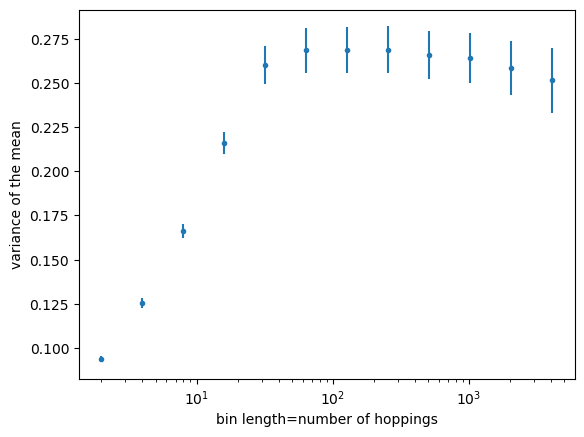

PyObject Text(24.0, 0.5, 'variance of the mean')

In [5]:
errorbar(lunghezze[1:end-1],sbin_graph,error, fmt=".")
plt.xscale(:log)
plt.xlabel("bin length=number of hoppings")
plt.ylabel("variance of the mean")

Il sistema "scorrela" dopo $\approx$ 800 passi , per cui simuleremo in sistema con nhop = 800 . N.B. non ricalcoliamo la lunghezza di correlazione per ogni g perchè la lunghezza di correlazione è una caratteristica del modello e non dipende da g. Verificato sotto per diversi valori di g

In [6]:
nhop=800; #numero di hopping fra una misura e la successiva

### ottimizziamo g valutando i vari valori dell'energia che si ottengono
Di nuovo, facciamo evolvere N_ensamble catene, valutando per ciascuna l'energia a diverse g. L'energia media a g fissata è presa come  media( energie medie della singola catena)(g fissata!!) => abbiamo un dataset con :
riga fissata = energia media del singolo esperimento a diverse g
colonna fissata = energia media a g fissata dei diversi esperimenti

Assumiamo come energia media finale a g fissata le medie delle colonne

In [7]:
n=2 #la block analysis lavora su bin che si dimezzano a ogni passo
nmeas=n^10
N_ensamble=20
g_val=[i for i in 10:0.5:20.0]
energy_matr=zeros(N_ensamble,length(g_val))
x0=Int(L/2)
for i in 1:length(g_val)
    g=g_val[i]
    for j in 1:N_ensamble
        output = mcchain(L,t,V,g,x0=x0,nmeas=nmeas,nhop=nhop)[1];
        energy_matr[j,i]=mean(output.ene)
    end
end
energy_matr

20×21 Array{Float64,2}:
 -21.3833  -35.3472  -58.3439  -96.2849  …  -174299.0  -2.87371e5  -473794.0
 -21.3833  -35.3374  -58.3439  -96.2752     -174299.0  -2.87371e5  -473794.0
 -21.3931  -35.3277  -58.3439  -96.2752     -174299.0  -2.87371e5  -473794.0
 -21.3833  -35.3277  -58.3537  -96.2752     -174299.0  -2.87371e5  -473794.0
 -21.3833  -35.3472  -58.3439  -96.2752     -174299.0  -2.87371e5  -473794.0
 -21.3931  -35.3374  -58.3439  -96.2752  …  -174299.0  -2.87371e5  -473794.0
 -21.3833  -35.3472  -58.3439  -96.2654     -174299.0  -2.87371e5  -473794.0
 -21.3735  -35.3374  -58.3439  -96.2752     -174299.0  -2.87371e5  -473794.0
 -21.3833  -35.3472  -58.3439  -96.2752     -174299.0  -2.87371e5  -473794.0
 -21.3735  -35.3374  -58.3341  -96.2752     -174299.0  -2.87371e5  -473794.0
 -21.3931  -35.3277  -58.3341  -96.2849  …  -174299.0  -2.87371e5  -473794.0
 -21.3735  -35.3374  -58.3439  -96.2849     -174299.0  -2.87371e5  -473794.0
 -21.3833  -35.3374  -58.3439  -96.2752     -174299.

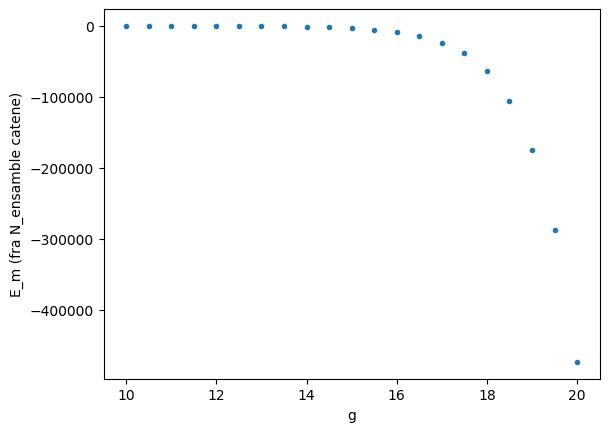

PyObject Text(24.140625000000014, 0.5, 'E_m (fra N_ensamble catene)')

In [8]:
average_e=[mean(energy_matr[:,i]) for i in 1:length(g_val)];
error = [std(energy_matr[:,i]) for i in 1:length(g_val)];
errorbar(g_val,average_e,error,fmt=".")
plt.xlabel("g")
plt.ylabel("E_m (fra N_ensamble catene)")

 Teoricamente ci aspetteremmo $g \rightarrow \infty$ per V>0. Prendiamo $g = 20$ 

### Cambiamo i V/t
se aumento V mi aspetto che la particella tenda ad andare subito a sinistra, quindi g ottimale può decrescere
se aumento t mi aspetto più fluttuazioni, quindi g ottimale deve crescere per limitare la probabilità di un salto

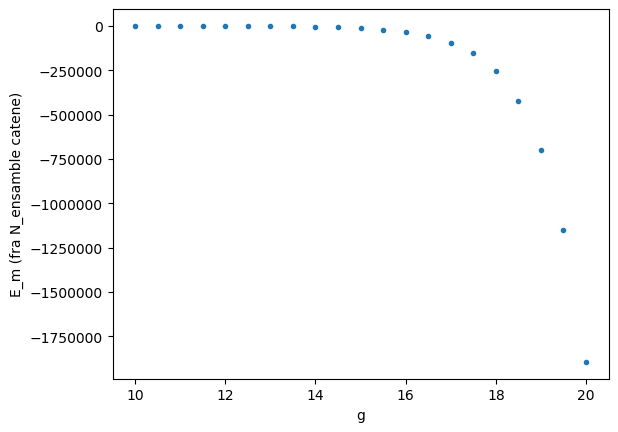

PyObject Text(24.140625000000014, 0.5, 'E_m (fra N_ensamble catene)')

In [9]:
L=30
V=1000.0
t=1.0
V_=V/t

nmeas=n^8
N_ensamble=10
g_val=[i for i in 10:0.5:20.0]
energy_matr=zeros(N_ensamble,length(g_val))
x0=Int(L/2)
for i in 1:length(g_val)
    g=g_val[i]
    for j in 1:N_ensamble
        output = mcchain(L,t,V,g,x0=x0,nmeas=nmeas,nhop=nhop)[1];
        energy_matr[j,i]=mean(output.ene)
    end
end
energy_matr
average_e=[mean(energy_matr[:,i]) for i in 1:length(g_val)]
error = [std(energy_matr[:,i]) for i in 1:length(g_val)]
errorbar(g_val,average_e,error,fmt=".")
plt.xlabel("g")
plt.ylabel("E_m (fra N_ensamble catene)")

Come aspettato, per V maggiore, a parità di g, l'energia media è minore, i.e. per V/t maggiore g può decrescere per avere un'enerfia di ground state ottimale uguale a un altro ground state con V/g maggiore

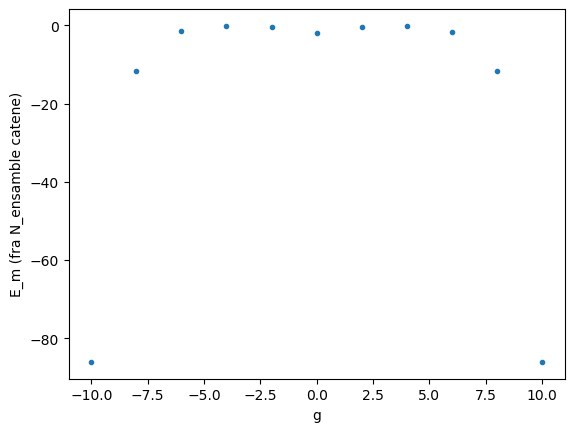

PyObject Text(24.14062500000002, 0.5, 'E_m (fra N_ensamble catene)')

In [10]:
L=30
V=1.0
t=1000.0
V_=V/t

nmeas=n^8
N_ensamble=20
g_val=[i for i in -10:2.0:10.0]
energy_matr=zeros(N_ensamble,length(g_val))
x0=Int(L/2)
for i in 1:length(g_val)
    g=g_val[i]
    for j in 1:N_ensamble
        output = mcchain(L,t,V,g,x0=x0,nmeas=nmeas,nhop=nhop)[1];
        energy_matr[j,i]=mean(output.ene)
    end
end
energy_matr
average_e=[mean(energy_matr[:,i]) for i in 1:length(g_val)]
error = [std(energy_matr[:,i]) for i in 1:length(g_val)]
errorbar(g_val,average_e,error,fmt=".")
plt.xlabel("g")
plt.ylabel("E_m (fra N_ensamble catene)")

Per hopping preponderante ( $\frac{V}{t}$ trascurabile ) l'hamiltoniana diventa $ \approx $ simmetrica per hopping a destra e sinistra, per cui i "ruoli" di g><0 diventano "simmetrici"

### Posizione media per conf ottimale a V/t=5
prendiamo g=20

In [11]:
L=30
V=5.0
t=1.0
V_=V/t
g=20.;
n=2 #la block analysis lavora su bin che si dimezzano a ogni passo
nmeas=n^13
nhop=800 #numero di hopping fra una misura e la successiva
output =mcchain(L,t,V,g,x0=15,nmeas=nmeas,nhop=nhop)[1];
N_ensamble=20
#g_val=[i for i in -10:2.0:10.0]
nhop=1 #numero di hopping fra una misura e la successiva
pos_v=zeros(N_ensamble)
x0=Int(L/2)
#for i in 1:length(g_val)
    #g=g_val[i]
    for j in 1:N_ensamble
        output = mcchain(L,t,V,g,x0=x0,nmeas=nmeas,nhop=nhop)[1];
        pos_v[j]=mean(output.pos)
    end
#end
average_pos=mean(pos_v) 
error = std(pos_v)
println("Average pos = ", average_pos, " +- " , error)

Average pos = 1.020220947265625 +- 0.004526969112900199


Ovviamente significa che la posizione media è 1